## Import your stuff

In [1]:
import numpy as np
import simulators.pisn.pisn_simulator as pisn
import pydelfi.ndes as ndes
from pydelfi import delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
import h5py
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
# generate sims for mu for fixed parameters and then we can calculate mean(mu) and Sigma = var(sim)

# z uniform in CV; dl_true = dl(z); dl_obs = exp(log(dl)+0.5* randn()), m_true = exp(log(M_min) + randn()*log(m_max/m_min))), m_obs = exp(log(m_true)+0.2* randn()), then feed this to delfi to get covmat and mean, and then work on the code as a test.



PISNSimulator = pisn.PISN_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return PISNSimulator.simulation(theta, seed)

simulator_args = None

## Set up the prior

In [3]:
lower = np.array([35.0,0.0,-2.0,35.0])
upper = np.array([140.0,1.0,0.0,90.0])
prior = priors.Uniform(lower, upper)

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [15]:
theta_fiducial = np.array([Planck15.H0.value, Planck15.Om0, -1.0, 52.0])

mu = PISNSimulator.dlofz(theta_fiducial)
Cinv = PISNSimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = PISNSimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(PISNSimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
print(Cinv)
print(dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv
print(Finv)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None


testcov = Compressor.compute_mean_covariance(simulator = simulator, nsims = 4000)
print(Compressor.C)
testcov = Compressor.C
Compressor = score.Gaussian(len(PISNSimulator.data), theta_fiducial, mu = mu, Cinv = testcov, dmudt = dmudt)
testcov = Compressor.compute_mean_covariance(simulator = simulator, nsims = 4000)
print(Compressor.C)

Compressor.compute_fisher()
Finv = Compressor.Finv
print(Finv)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

[[5.47007900e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.64045086e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.31637857e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.74633262e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.45123338e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.38099701e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.16259783e-01 0.00000000e+00
  0.00000000e+00]
 [0.00


[[ 1.89656191e-03 -2.48211938e-04  4.38449717e-05  1.01306963e-04
   9.07080334e-05 -7.28531637e-04  4.63230636e-04 -5.29555635e-04
  -4.69655302e-04]
 [-2.48211938e-04  6.28979401e-02  1.39746581e-03  1.48529311e-04
  -2.36480139e-03 -5.29561747e-03 -3.04440314e-04 -1.62207976e-02
  -1.81666797e-03]
 [ 4.38449717e-05  1.39746581e-03  1.93427828e-01 -4.64812167e-03
   4.28554090e-03 -3.75359230e-03 -1.42830467e-02  3.96272306e-03
  -2.92385646e-02]
 [ 1.01306963e-04  1.48529311e-04 -4.64812167e-03  3.57292830e-01
  -2.15216173e-03  1.01796063e-02 -1.06462413e-02  1.45974508e-02
   2.20620731e-02]
 [ 9.07080334e-05 -2.36480139e-03  4.28554090e-03 -2.15216173e-03
   7.19609429e-01 -1.54492402e-02 -2.38591981e-02 -7.38072088e-03
  -2.13749758e-03]
 [-7.28531637e-04 -5.29561747e-03 -3.75359230e-03  1.01796063e-02
  -1.54492402e-02  1.20795917e+00  1.02123317e-02  1.70280607e-02
   5.92777352e-02]
 [ 4.63230636e-04 -3.04440314e-04 -1.42830467e-02 -1.06462413e-02
  -2.38591981e-02  1.021233


[[ 1.81857676e-03  4.15254480e-05 -2.47756828e-04 -9.46309108e-04
  -2.25856575e-04  4.70901656e-05 -5.85436643e-04  1.51779318e-03
   3.79249478e-04]
 [ 4.15254480e-05  6.03199482e-02 -2.44239206e-04  1.98085695e-05
  -6.05003201e-03  6.36190038e-04 -9.99863379e-03  1.28294288e-02
  -8.76666029e-03]
 [-2.47756828e-04 -2.44239206e-04  1.91607270e-01  2.75414880e-03
   8.28002853e-03 -6.68536740e-03 -1.20773550e-02  6.38651650e-03
  -2.26152456e-02]
 [-9.46309108e-04  1.98085695e-05  2.75414880e-03  3.61395600e-01
   8.50217730e-03  5.82693717e-03 -2.64459179e-02  6.23446145e-04
   8.06745909e-03]
 [-2.25856575e-04 -6.05003201e-03  8.28002853e-03  8.50217730e-03
   7.32103449e-01 -1.25009843e-02  1.05532477e-03  2.55228113e-02
   1.33390690e-03]
 [ 4.70901656e-05  6.36190038e-04 -6.68536740e-03  5.82693717e-03
  -1.25009843e-02  1.15155983e+00  4.57981115e-03 -8.69469344e-03
  -2.53637333e-02]
 [-5.85436643e-04 -9.99863379e-03 -1.20773550e-02 -2.64459179e-02
   1.05532477e-03  4.579811

## Load in the compressed data

In [16]:
compressed_data = compressor(PISNSimulator.data, compressor_args)

## Define ensemble of NDEs

In [17]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=4, n_data=4, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=4, n_data=4, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [18]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['h_0', 'Omega_0', 'omega','m90'], 
                            results_dir = "simulators/pisn/results/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs


Sampling approximate posterior...
Done.


/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


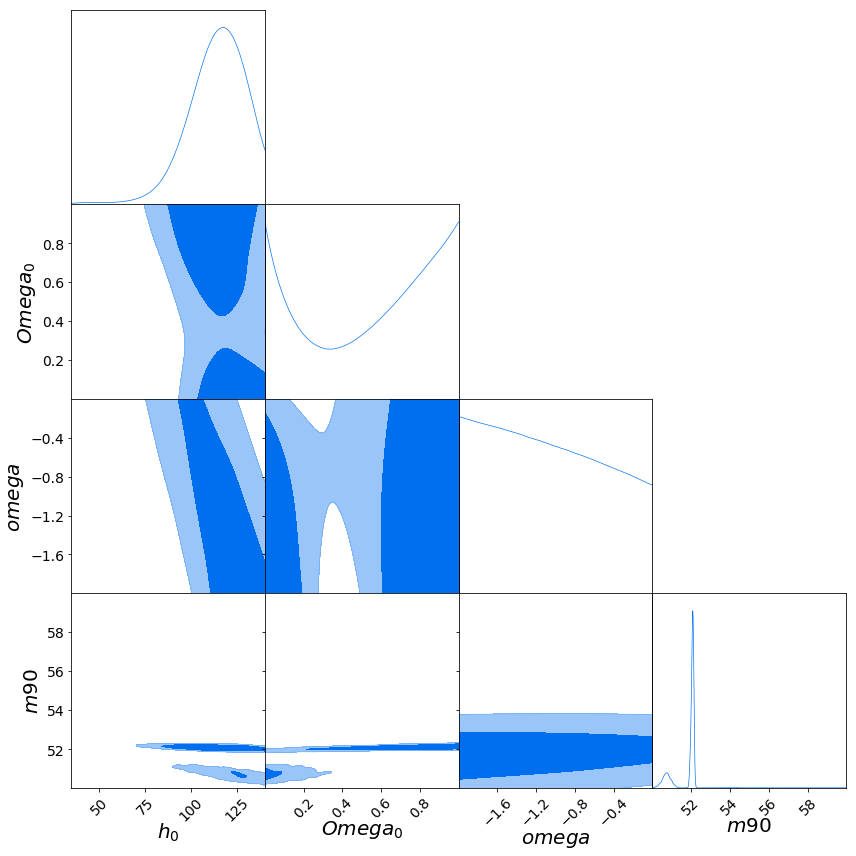

In [19]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood


Population 1/10
Sampling proposal density...
Done.


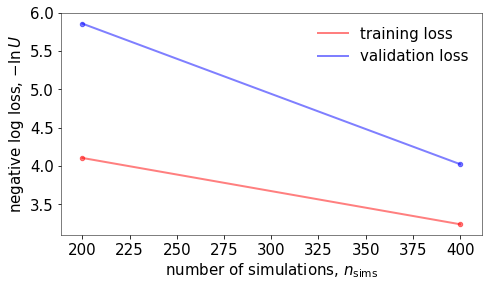

Population 2/10
Sampling proposal density...
72/|/ 24%|| 72/300 [00:42<00:50,  4.56it/s, train loss=2.78, val loss=3.97, refresh=1]Done.


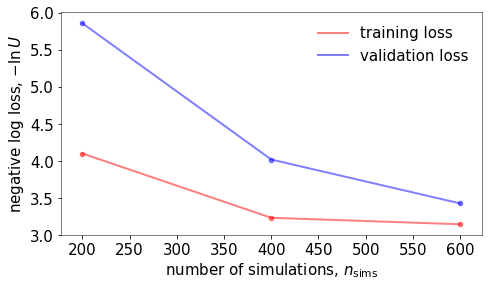

Population 3/10
Sampling proposal density...
33/|/ 11%|| 33/300 [00:24<01:06,  4.01it/s, train loss=2.87, val loss=3.38, refresh=1]Done.


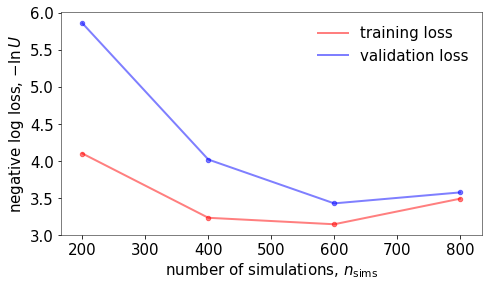

Population 4/10
Sampling proposal density...
59/|/ 20%|| 59/300 [00:33<00:27,  8.88it/s, train loss=2.84, val loss=3.41, refresh=1]Done.


102/|/ 34%|| 102/300 [00:58<01:09,  2.83it/s, train loss=3.71, val loss=4, refresh=1]


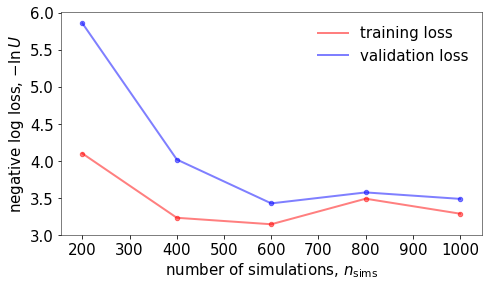

Population 5/10
Sampling proposal density...
30/|/ 10%|| 30/300 [00:27<01:20,  3.34it/s, train loss=2.97, val loss=3.41, refresh=1]Done.


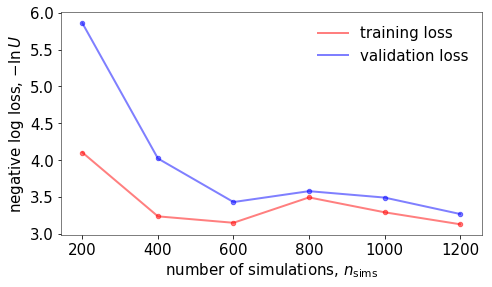

Population 6/10
Sampling proposal density...
69/|/ 23%|| 69/300 [00:34<00:26,  8.74it/s, train loss=2.76, val loss=3.02, refresh=1]Done.


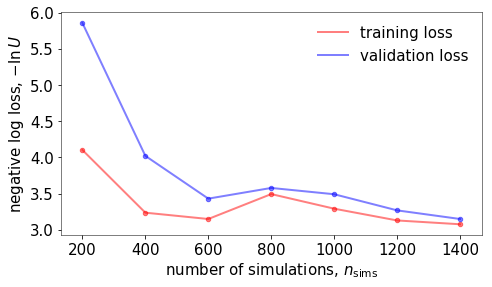

Population 7/10
Sampling proposal density...
40/|/ 13%|| 40/300 [00:23<00:35,  7.31it/s, train loss=2.68, val loss=2.77, refresh=1]Done.


26/|/  9%|| 26/300 [00:17<03:41,  1.24it/s, train loss=3.09, val loss=3.84, refresh=1]


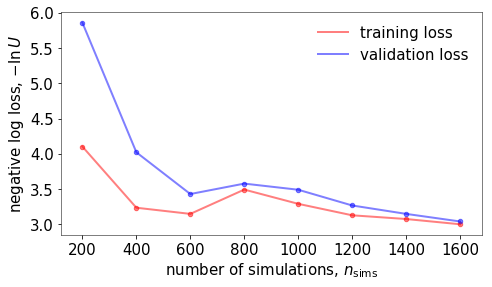

Population 8/10
Sampling proposal density...
24/|/  8%|| 24/300 [00:20<02:07,  2.17it/s, train loss=2.63, val loss=2.8, refresh=1]Done.


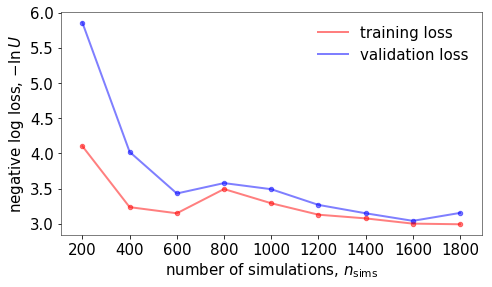

Population 9/10
Sampling proposal density...
36/|/ 12%|| 36/300 [00:27<00:58,  4.51it/s, train loss=2.67, val loss=3, refresh=1]Done.


44/|/ 15%|| 44/300 [00:20<01:27,  2.93it/s, train loss=3.12, val loss=2.82, refresh=1]


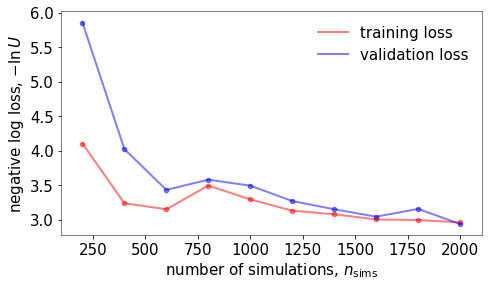

Population 10/10
Sampling proposal density...
76/|/ 25%|| 76/300 [00:42<00:46,  4.86it/s, train loss=2.82, val loss=2.7, refresh=1]Done.


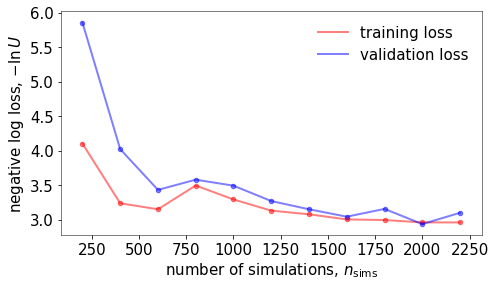

32/|/ 11%|| 32/300 [00:31<01:16,  3.52it/s, train loss=2.75, val loss=2.82, refresh=1]

In [20]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

## Sample the learned posterior

In [21]:
posterior_samples = DelfiEnsemble.emcee_sample()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

/Users/hyraland/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


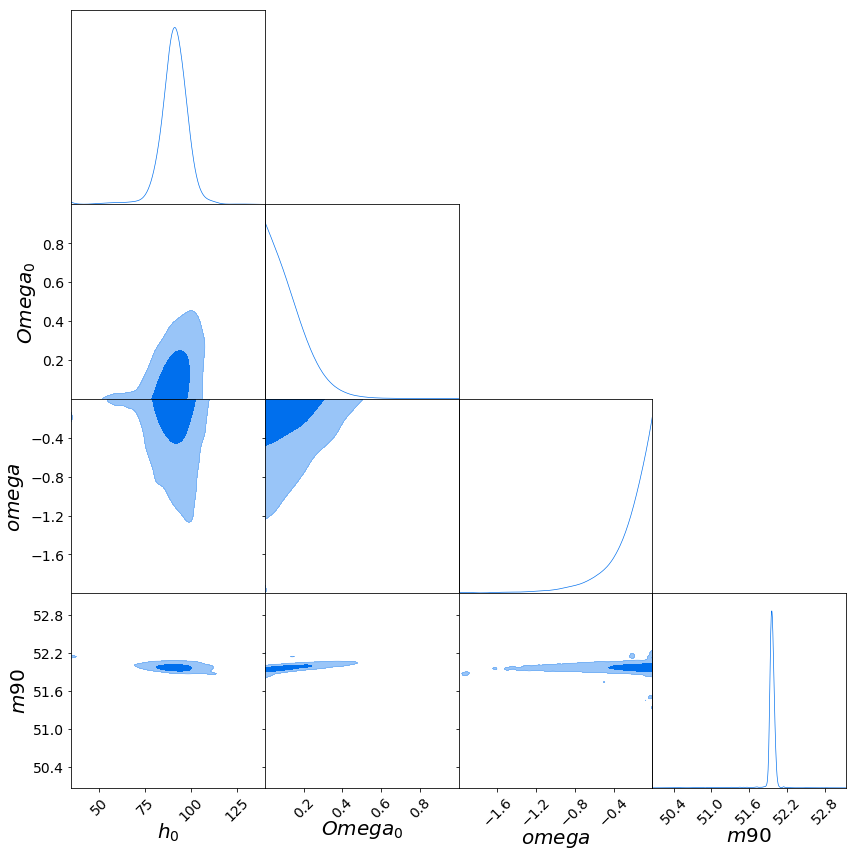

In [22]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])

In [43]:
print(np.random.normal(0, 1, len(PISNSimulator.L)))
print(np.dot(PISNSimulator.L, np.random.normal(0, 1, len(PISNSimulator.L))))
print(PISNSimulator.L)
print(PISNSimulator.dlofz(theta_fiducial))
print(PISNSimulator.data)
print(PISNSimulator.simulation(theta_fiducial,None))
print(PISNSimulator.simulation(theta_fiducial,None))
print(PISNSimulator.simulation(theta_fiducial,None))
print(PISNSimulator.simulation(theta_fiducial,None))
print(PISNSimulator.simulation(theta_fiducial,None))
print(PISNSimulator.C)

[-0.36158353  0.65469841 -1.4798518   0.58285787 -0.46599733  0.58447912
  0.67652315  1.65348001  1.639936  ]
[ 0.03284596 -0.30491284  0.05253598 -0.15137927 -0.39558859 -0.44474758
 -0.8951486   1.83195546 -2.34916635]
[[0.0427566  0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.24689846 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.43370262 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.60342518 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.83010183 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.09232571
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.39176481 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.77105414 0.        ]
 [